In [2]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torchvision import datasets, transforms


In [136]:
class VariationalAutoEncoder(torch.nn.Module):

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    all_weights = {}
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq

    cost = 0
    optimizer = 0
    
    learning_rate = 0
    network_weights = {}
    
    def __init__(self,network_architecture,transfer_fct=torch.sigmoid):
        super(VariationalAutoEncoder,self).__init__()
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정


    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        torch.set_default_dtype(torch.double)


        self.all_weights['weights_recog'] = { 'h1' : torch.nn.Parameter(self.xavier_init(n_input,n_hidden_recog_1),requires_grad = True), \
                                         'h2' : torch.nn.Parameter(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2),requires_grad = True), \
                                         'out_mean': torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z),requires_grad = True), \
                                         'out_log_sigma': torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z),requires_grad = True)}

        self.all_weights['biases_recog'] = { 'b1' : torch.nn.Parameter(torch.zeros([n_hidden_recog_1]),requires_grad = True), \
                                        'b2' : torch.nn.Parameter(torch.zeros([n_hidden_recog_2]),requires_grad = True), \
                                        'out_mean': torch.nn.Parameter(torch.zeros([n_z]),requires_grad = True), \
                                        'out_log_sigma': torch.nn.Parameter(torch.zeros([n_z]),requires_grad = True)}        
        
        self.all_weights['weights_gener'] = {'h1': torch.nn.Parameter(self.xavier_init(n_z, n_hidden_gener_1),requires_grad = True), \
                                        'h2': torch.nn.Parameter(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2),requires_grad = True), \
                                        'out_mean': torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input),requires_grad = True), \
                                        'out_log_sigma': torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input),requires_grad = True)}

        self.all_weights['biases_gener'] = {'b1': torch.nn.Parameter(torch.zeros([n_hidden_gener_1]),requires_grad = True), \
                                       'b2': torch.nn.Parameter(torch.zeros([n_hidden_gener_2]),requires_grad = True), \
                                       'out_mean': torch.nn.Parameter(torch.zeros([n_input]),requires_grad = True), \
                                       'out_log_sigma': torch.nn.Parameter(torch.zeros([n_input]),requires_grad = True)}
        return self.all_weights
    
    def forward (self, x):
        self.x = x
        #recognition network
        weights, biases = self.all_weights["weights_recog"], self.all_weights["biases_recog"] 
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(weights,biases,x)
        
        #reparameterization
        self.z = self._reparameterization(self.z_mean, self.z_log_sigma_sq)

        #generator network
        weights, biases = self.all_weights["weights_gener"], self.all_weights["biases_gener"]       
        self.x_reconstr_mean = self._generator_network(weights,biases, self.z)
        
        reconstr_loss = -torch.sum(x*torch.log(1e-10+self.x_reconstr_mean)+(1-x)*torch.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss = -0.5*torch.sum(1+self.z_log_sigma_sq-torch.square(self.z_mean)-torch.exp(self.z_log_sigma_sq),1)

        self.cost = torch.mean(reconstr_loss+latent_loss)
        return self.cost
        
    def _recognition_network(self,weights,biases,x=None): 

        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        layer_1 = self.transfer_fct(torch.add(torch.matmul(x, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(torch.add(torch.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        
        z_mean = torch.add(torch.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = torch.add(torch.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases,z=None)
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        
        layer_1 = self.transfer_fct(torch.add(torch.matmul(z, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*Z)
        layer_2 = self.transfer_fct(torch.add(torch.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = torch.sigmoid(torch.add(torch.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2
        return x_reconstr_mean

    def _reparameterization(self, z_mean, z_log_sigma_sq):
        # Z mean과 Z sigma를 이용해 Z를 reparameterize하는 method
        # Input : z_mean, z_log_sigma_sq
        # Output : z

        n_z = self.network_architecture["n_z"]
        n_batch = len(z_log_sigma_sq)
        eps = torch.normal(mean=0, std=1, size=(n_batch, n_z), dtype=torch.double)

        z = torch.add(z_mean,torch.mul(torch.sqrt(torch.exp(z_log_sigma_sq)),eps))
        
        return z
    
    def get_weights(self):
        # Training될 weight를 모두 반환하는 method
        
        weights = []
        weights.append(self.all_weights["weights_recog"]['h1'])
        weights.append(self.all_weights["biases_recog"]['b1'])
        weights.append(self.all_weights["weights_recog"]['h2'])
        weights.append(self.all_weights["biases_recog"]['b2'])
        weights.append(self.all_weights["weights_recog"]['out_mean'])
        weights.append(self.all_weights["biases_recog"]['out_mean'])        
        weights.append(self.all_weights["weights_recog"]['out_log_sigma'])
        weights.append(self.all_weights["biases_recog"]['out_log_sigma'])
        weights.append(self.all_weights["weights_gener"]['h1'])
        weights.append(self.all_weights["biases_gener"]['b1'])
        weights.append(self.all_weights["weights_gener"]['h2'])
        weights.append(self.all_weights["biases_gener"]['b2'])
        weights.append(self.all_weights["weights_gener"]['out_mean'])
        weights.append(self.all_weights["biases_gener"]['out_mean'])     
        
        return weights
    
    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.get_weights(), lr=learning_rate)


    def transform(self,x):
        # VAE의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x
        # Output : z_mean
        z_mean, z_log_sigma_sq = self._recognition_network(self.all_weights['weights_recog'],self.all_weights["biases_recog"],x)
        return z_mean

    def generate(self,z_mu=None):
        # VAE의 decoder network를 통하여 reconstruct된 mean을 return하는 메소드
        # Input : z_mu
        # Output : reconstr_mean
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
            
        reconstr_mean = self._generator_network(self.all_weights["weights_gener"],self.all_weights["biases_gener"],z_mu)
        return reconstr_mean
    
    def reconstruct(self,x):
        # VAE를 통하여 X를 reconstruct한 후, 이의 mean을 return하는 메소드
        # Input : x
        # Output : (VAE를 통한) x_reconstr_mean
        
        return self.generate(self.transform(x))

        
    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))
        return torch.DoubleTensor(fan_in, fan_out).uniform_(low, high)

    def train(self,trainX,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # VAE를 생성하고, trainX를 training하는 메소드
        # Input : trainX, batch_size, training_epochs, learning_rate
        # Output : None        
        total_costs = np.zeros(training_epochs)
        
        self.all_weights = self._initialize_weights(**self.network_architecture) #weight 초기화
        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성
        
        
        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = len(trainX) # total batch : 전체 batch의 갯수

            for x_batch, y_batch in trainX: 
                batch = torch.reshape(x_batch,(100,784)).double()
                cost = self.forward(batch)
                self.optimizer.zero_grad()
                cost.backward()
                self.optimizer.step()
                
                avg_cost += cost / total_batch
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간
       
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return


    def plotReconstruct(self,testData,strFileName):
    # testData를 VAE를 통해 reconstruct한 후, Input test image와 reconstructedf output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        x_reconstruct = self.reconstruct(testData) # x_reconstruct : testData를 이용하여 X를 reconstruct한 데이터
        plt.figure(figsize=(8, 12))
        for i in range(5): # testData의 처음 5개를 plot

            # Original Input image plot
            plt.subplot(5, 2, 2 * i + 1)
            plt.imshow(testData[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()

            # Reconstructed Output image plot
            plt.subplot(5, 2, 2 * i + 2)
            temp = torch.reshape(x_reconstruct[i],[28,28])
            temp = temp.cpu().detach().numpy()
            plt.imshow(temp, vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환

#             plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Reconstruction")
            plt.title("Reconstruction")
            plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        z_mu = self.transform(testDataFeature)
        z_mu = z_mu.cpu().detach().numpy()


        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=testDataClass)
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotManifold2D(self,intNumX1,intNumX2,maxX1,minX1,maxX2,minX2,batch_size,strFileName):
        # walking in latent space를 표현하는 메소드
        x1s = np.linspace(minX1, maxX1, intNumX1)
        x2s = np.linspace(minX2, maxX2, intNumX2)
        canvas = np.empty((28*intNumX2,28*intNumX1))
        for i, yi in enumerate(x1s):
            for j, xi in enumerate(x2s):
                z_mu = torch.tensor(np.array([[xi,yi]]*batch_size))
                x_mean = self.generate(z_mu)
                canvas[(intNumX1-i-1)*28:(intNumX1-i)*28,j*28:(j+1)*28] = torch.reshape(x_mean[0],[28,28]).detach().numpy()
        plt.figure(figsize=(8, 6))
        xi, yi = np.meshgrid(x1s,x2s)
        plt.imshow(canvas,origin='upper',cmap='gray')
        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')     
        plt.close()
        

In [113]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)


Epoch :  0001  Cost =  -4095.101515381
Elapsed Time : 57.60336399078369
Epoch :  0002  Cost =  -4288.822218143
Elapsed Time : 113.17607808113098
Epoch :  0003  Cost =  -4289.225778124
Elapsed Time : 163.19957089424133
Epoch :  0004  Cost =  -4701.897469861
Elapsed Time : 213.5394389629364
Epoch :  0005  Cost =  -5206.635580645
Elapsed Time : 263.22972798347473
Epoch :  0006  Cost =  -5649.536568108
Elapsed Time : 312.0560088157654
Epoch :  0007  Cost =  -6239.102189004
Elapsed Time : 363.1323130130768
Epoch :  0008  Cost =  -6647.564619065
Elapsed Time : 412.66045212745667
Epoch :  0009  Cost =  -6936.474867724
Elapsed Time : 461.31722497940063
Epoch :  0010  Cost =  -7103.548742588
Elapsed Time : 511.1701159477234
Epoch :  0011  Cost =  -7251.745939040
Elapsed Time : 560.6300468444824
Epoch :  0012  Cost =  -7371.517048661
Elapsed Time : 609.4334778785706
Epoch :  0013  Cost =  -7464.579839395
Elapsed Time : 660.0591199398041
Epoch :  0014  Cost =  -7561.780608711
Elapsed Time : 709.4

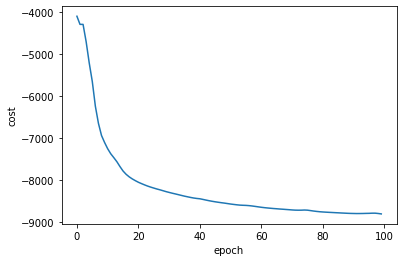

In [137]:
# z dimension이 10인 VAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

vae = VariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성  
vae.train(train_loader,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training



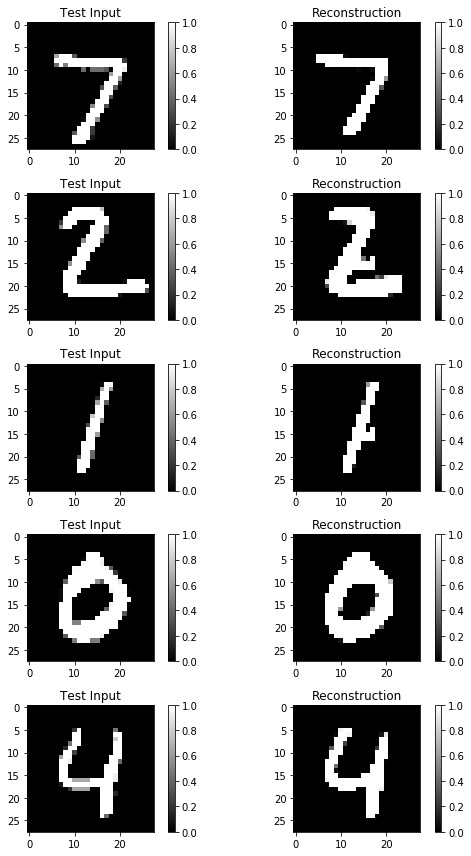

In [138]:
y_test = 0
for testX, testY in test_loader:
    x_test = torch.reshape(testX,(10000,784)).double()
    y_test = testY
vae.plotReconstruct(x_test,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot

Epoch :  0001  Cost =  -4094.223542839
Elapsed Time : 79.16088223457336
Epoch :  0002  Cost =  -4288.791407032
Elapsed Time : 166.5375690460205
Epoch :  0003  Cost =  -4289.191095698
Elapsed Time : 239.58439111709595
Epoch :  0004  Cost =  -4289.267290809
Elapsed Time : 321.2110662460327
Epoch :  0005  Cost =  -4666.688331981
Elapsed Time : 394.9317030906677
Epoch :  0006  Cost =  -5036.437941559
Elapsed Time : 470.4649341106415
Epoch :  0007  Cost =  -5207.198224502
Elapsed Time : 548.0102891921997
Epoch :  0008  Cost =  -5324.657190868
Elapsed Time : 634.1704120635986
Epoch :  0009  Cost =  -5434.053317652
Elapsed Time : 715.4811420440674
Epoch :  0010  Cost =  -5651.557019542
Elapsed Time : 807.5862510204315
Epoch :  0011  Cost =  -5864.186188073
Elapsed Time : 886.6064641475677
Epoch :  0012  Cost =  -5979.004611051
Elapsed Time : 971.9479041099548
Epoch :  0013  Cost =  -6063.230990039
Elapsed Time : 1038.0972731113434
Epoch :  0014  Cost =  -6124.993808805
Elapsed Time : 1106.528

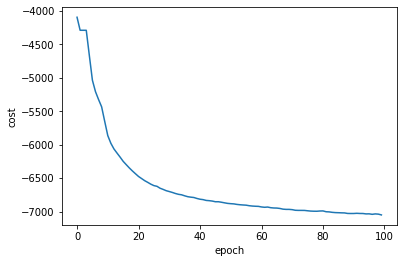

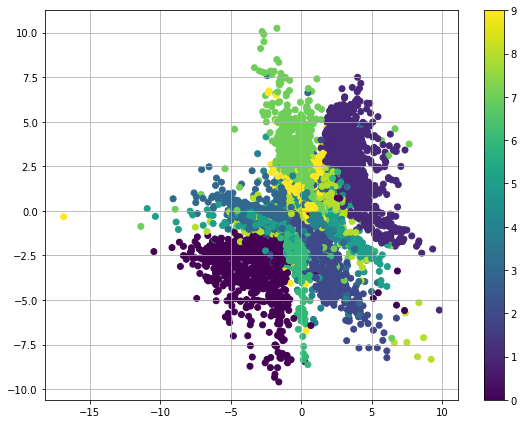

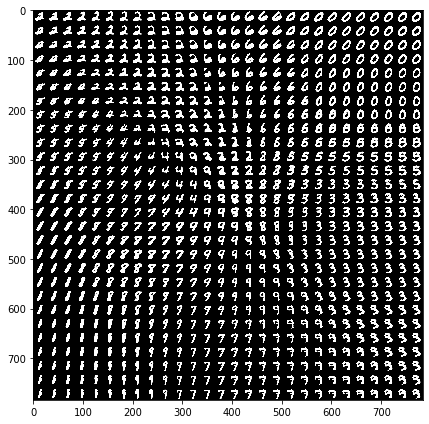

In [139]:
# z dimentsion이 2인 VAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)



vae2D = VariationalAutoEncoder(network_architecture2D)
vae2D.train(train_loader,batch_size=1000,training_epochs=100,learning_rate=0.001)
vae2D.plotScatter2D(x_test,y_test,'./log/VAE-2D-Scatter.png')
vae2D.plotManifold2D(28,28,-3,3,-3,3,1000,'./log/VAE-2D-Manifold.png')